In [1]:
pip install pandas


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from random import randint
from torchvision.transforms import Resize
from torch.utils.data import random_split
from PIL import Image
from torchvision import transforms
import pandas as pd
import csv
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=0)
        self.act1  = nn.ReLU()
        self.bn1   = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
       
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, padding=0)
        self.act2  = nn.ReLU()
        self.bn2   = nn.BatchNorm2d(12)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=0)
        self.act3  = nn.ReLU()
        self.bn3   = nn.BatchNorm2d(24)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, padding=0)
        self.act4  = nn.ReLU()
        self.bn4   = nn.BatchNorm2d(32)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0)
        self.act5  = nn.ReLU()
        self.bn5   = nn.BatchNorm2d(64)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1   = nn.Linear(896, 512)
        self.act6  = nn.ReLU()
        
        self.fc2   = nn.Linear(512, 256)
        self.act7  = nn.Tanh()
        
        self.fc3   = nn.Linear(256, 28)
        
        self.flatten = nn.Flatten(1)
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.act4(x)
        x = self.bn4(x)
        x = self.pool4(x)
        
        x = self.conv5(x)
        x = self.act5(x)
        x = self.bn5(x)
        x = self.pool5(x)
        
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.act6(x)
        x = self.fc2(x)
        x = self.act7(x)
        x = self.fc3(x)
        
        return x

In [3]:
net = Net()

In [4]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=5e-5)

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        full_list = list(Path(img_dir).glob("*.jpg"))
        self.images = full_list[:1024]
        
        app_labels = pd.read_csv('app_details.csv')
        # ui_labels = pd.read_csv('ui_details.csv')
        labels = app_labels.Category.astype('category').cat.codes
        self.labels = list(labels)
        
        # categories = set()
        # for element in self.labels:
        # categories.add(element)
        # print(len(categories))
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        transform = transforms.Compose([transforms.Resize((180, 320)), transforms.ToTensor()])
        image = transform(image)
        label = int(self.labels[idx])
        return image, label

In [6]:
pathname = "unique_uis/combined"
ds = CustomImageDataset(pathname)

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
train, test = random_split(ds, [train_size, test_size])

train_loader = DataLoader(train, batch_size=16, shuffle=True)

test_loader = DataLoader(test, batch_size=16, shuffle=False)

In [7]:
net.train()
list_of_losses = []

for epoch_index in range(100):
    for batch, label in train_loader:
        optimizer.zero_grad()
        pred = net(batch)
        loss_val = loss(pred, label)
        list_of_losses.append(loss_val.data.cpu())
        loss_val.backward()
        optimizer.step()
        
print("ended")

ended


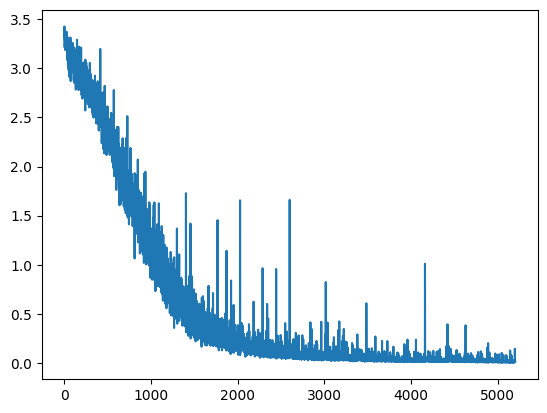

In [8]:
numbers = []
for i in range(len(list_of_losses)):
    numbers.append(i)
plt.plot(numbers, list_of_losses)